# Synthetic Data Generation for Imbalanced Classification: Results Analysis
 
### 1. Introduction
 
This notebook analyzes the experimental results comparing three synthetic data generation methods (CTGAN, TVAE, DDPM) against a baseline classifier across varying levels of class imbalance in the Mammographic Mass dataset.

**Research Questions:**
1. At what imbalance ratios do synthetic methods significantly outperform baseline?
2. Does synthetic data quality degrade linearly or exponentially with imbalance ratio?
3. What is the maximum imbalance ratio each method can handle while maintaining F1 > 0.5?

**Experimental Design:**
- **Imbalance Ratios (IR):** 1:1, 5:1, 10:1, 20:1, 50:1, 100:1 (Benign:Malignant)
- **Generators:** CTGAN, TVAE, DDPM (naive oversampling of minority class)
- **Baseline:** Random Forest trained on imbalanced data without augmentation
- **Control:** Random Forest trained on size-matched balanced datasets
- **Evaluation Metrics:** F1-score (minority), ROC-AUC, Precision, Recall

In [48]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Configuration
RESULTS_PATH = Path("../results/tables/")
FIGURES_PATH = Path("../results/figures/")
FIGURES_PATH.mkdir(exist_ok=True)

COLOR_PALETTE = 'Set2'  
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Load results
summary_df = pd.read_csv(RESULTS_PATH / "summary_experiment_results.csv")
detailed_df = pd.read_csv(RESULTS_PATH / "detailed_experiment_results.csv")

print("\n")
print(" DATASET SUMMARY ")
print("\n")
print(f"Total experimental conditions: {len(summary_df)}")
print(f"Total individual runs: {len(detailed_df)}")
print(f"\nDataset types: {summary_df['dataset_type'].unique()}")
print(f"Models tested: {summary_df['model'].unique()}")
print(f"Imbalance ratios: {sorted(summary_df['imbalance_ratio'].unique())}")



 DATASET SUMMARY 


Total experimental conditions: 36
Total individual runs: 36

Dataset types: ['control' 'imbalanced']
Models tested: ['baseline' 'ctgan' 'tvae']
Imbalance ratios: ['100:1', '10:1', '1:1', '20:1', '50:1', '5:1']


### 2. Data Preparation and Quality Check
 
First, let's ensure our data is properly formatted and check for any anomalies.


In [49]:
# Convert imbalance ratio to numeric for plotting
def extract_ir_numeric(ir_str):
    """Extract numeric value from 'X:1' format"""
    return int(ir_str.split(':')[0])

summary_df['ir_numeric'] = summary_df['imbalance_ratio'].apply(extract_ir_numeric)
detailed_df['ir_numeric'] = detailed_df['imbalance_ratio'].apply(extract_ir_numeric)

# Sort by imbalance ratio for consistent plotting
summary_df = summary_df.sort_values(['dataset_type', 'ir_numeric', 'model'])
detailed_df = detailed_df.sort_values(['dataset_type', 'ir_numeric', 'model'])

print("\nData structure check:")
print(summary_df[['dataset_type', 'imbalance_ratio', 'model', 'f1_minority_mean']].head(10))



Data structure check:
   dataset_type imbalance_ratio     model  f1_minority_mean
6       control             1:1  baseline          0.802083
7       control             1:1     ctgan          0.795812
8       control             1:1      tvae          0.812500
15      control             5:1  baseline          0.759358
16      control             5:1     ctgan          0.761905
17      control             5:1      tvae          0.773196
3       control            10:1  baseline          0.774194
4       control            10:1     ctgan          0.771739
5       control            10:1      tvae          0.797872
9       control            20:1  baseline          0.767568


### 3. Overall Performance Comparison
 
Let's start with a high-level view: how do synthetic data methods perform compared to baseline across all conditions?


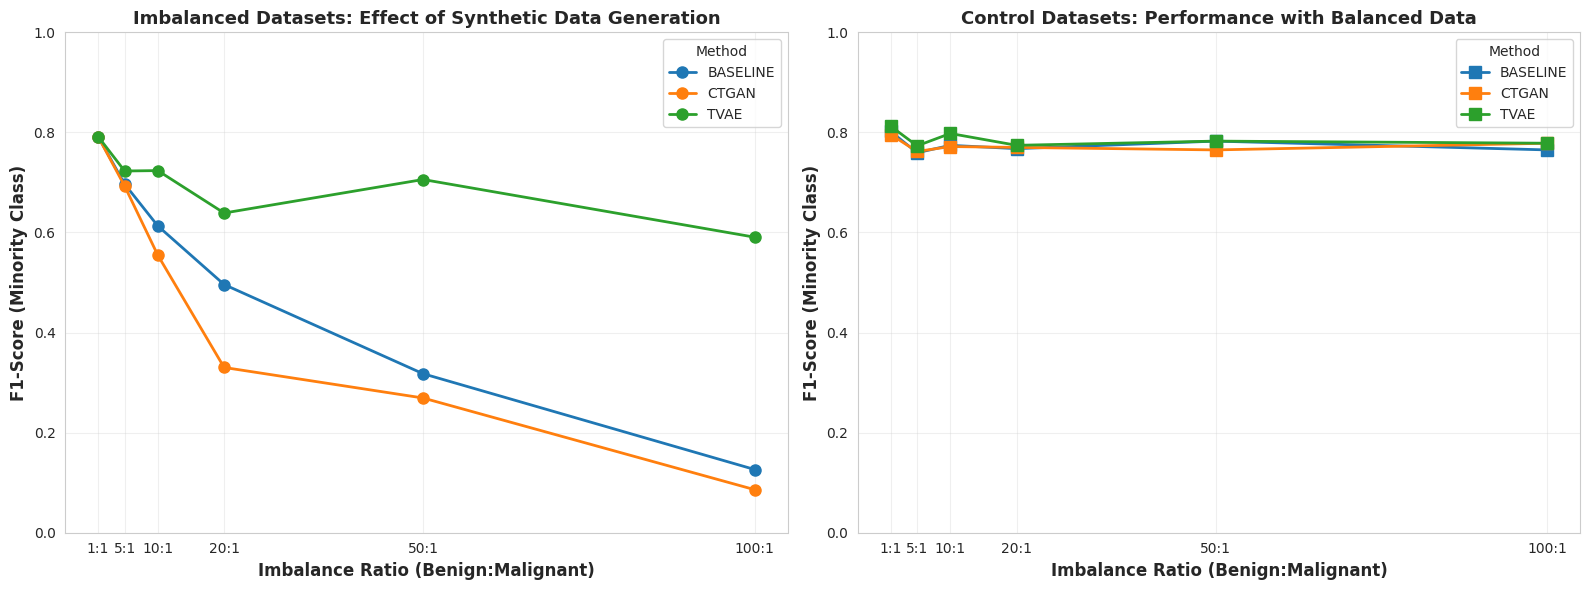

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced']
control_data = summary_df[summary_df['dataset_type'] == 'control']

# Plot 1: Imbalanced datasets
ax = axes[0]
for model in ['baseline', 'ctgan', 'tvae']:
    model_data = imbalanced_data[imbalanced_data['model'] == model]
    ax.plot(model_data['ir_numeric'], model_data['f1_minority_mean'], 
            marker='o', linewidth=2, markersize=8, label=model.upper())
    ax.fill_between(model_data['ir_numeric'],
                    model_data['f1_minority_mean'] - model_data['f1_minority_std'],
                    model_data['f1_minority_mean'] + model_data['f1_minority_std'],
                    alpha=0.2)

#ax.set_xscale('log')
ax.set_xlabel('Imbalance Ratio (Benign:Malignant)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score (Minority Class)', fontsize=12, fontweight='bold')
ax.set_title('Imbalanced Datasets: Effect of Synthetic Data Generation', 
             fontsize=13, fontweight='bold')
ax.legend(title='Method', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks([1, 5, 10, 20, 50, 100])
ax.set_xticklabels(['1:1', '5:1', '10:1', '20:1', '50:1', '100:1'])
ax.set_ylim(0, 1)

# Plot 2: Control datasets
ax = axes[1]
for model in ['baseline', 'ctgan', 'tvae']:
    model_data = control_data[control_data['model'] == model]
    ax.plot(model_data['ir_numeric'], model_data['f1_minority_mean'], 
            marker='s', linewidth=2, markersize=8, label=model.upper())
    ax.fill_between(model_data['ir_numeric'],
                    model_data['f1_minority_mean'] - model_data['f1_minority_std'],
                    model_data['f1_minority_mean'] + model_data['f1_minority_std'],
                    alpha=0.2)

#ax.set_xscale('log')
ax.set_xlabel('Imbalance Ratio (Benign:Malignant)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score (Minority Class)', fontsize=12, fontweight='bold')
ax.set_title('Control Datasets: Performance with Balanced Data', 
             fontsize=13, fontweight='bold')
ax.legend(title='Method', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks([1, 5, 10, 20, 50, 100])
ax.set_xticklabels(['1:1', '5:1', '10:1', '20:1', '50:1', '100:1'])
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'overall_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



**Imbalanced Datasets (Left Panel):**
- **TVAE maintains effectiveness across all imbalance ratios** (F1 ≥ 0.59), while baseline and CTGAN fail catastrophically beyond 20:1 (F1 < 0.35)
- **Critical threshold**: Baseline and CTGAN become ineffective (F1 < 0.5) between 10:1 and 20:1 ratios
- **Non-linear degradation**: TVAE shows stable performance from 1:1 to 20:1, then plateaus at severe imbalance rather than continuing to decline

**Control Datasets (Right Panel):**
- Control datasets maintain relatively stable performance (F1 ≈ 0.76-0.82), suggesting **insufficient minority samples** rather than imbalance ratio itself drives performance loss
- Erratic fluctuations indicate need for multiple experimental runs

### 4. Performance Degradation Analysis
 
As imbalance increases, we expect performance to degrade. Let's quantify this effect and see if synthetic data mitigates it.


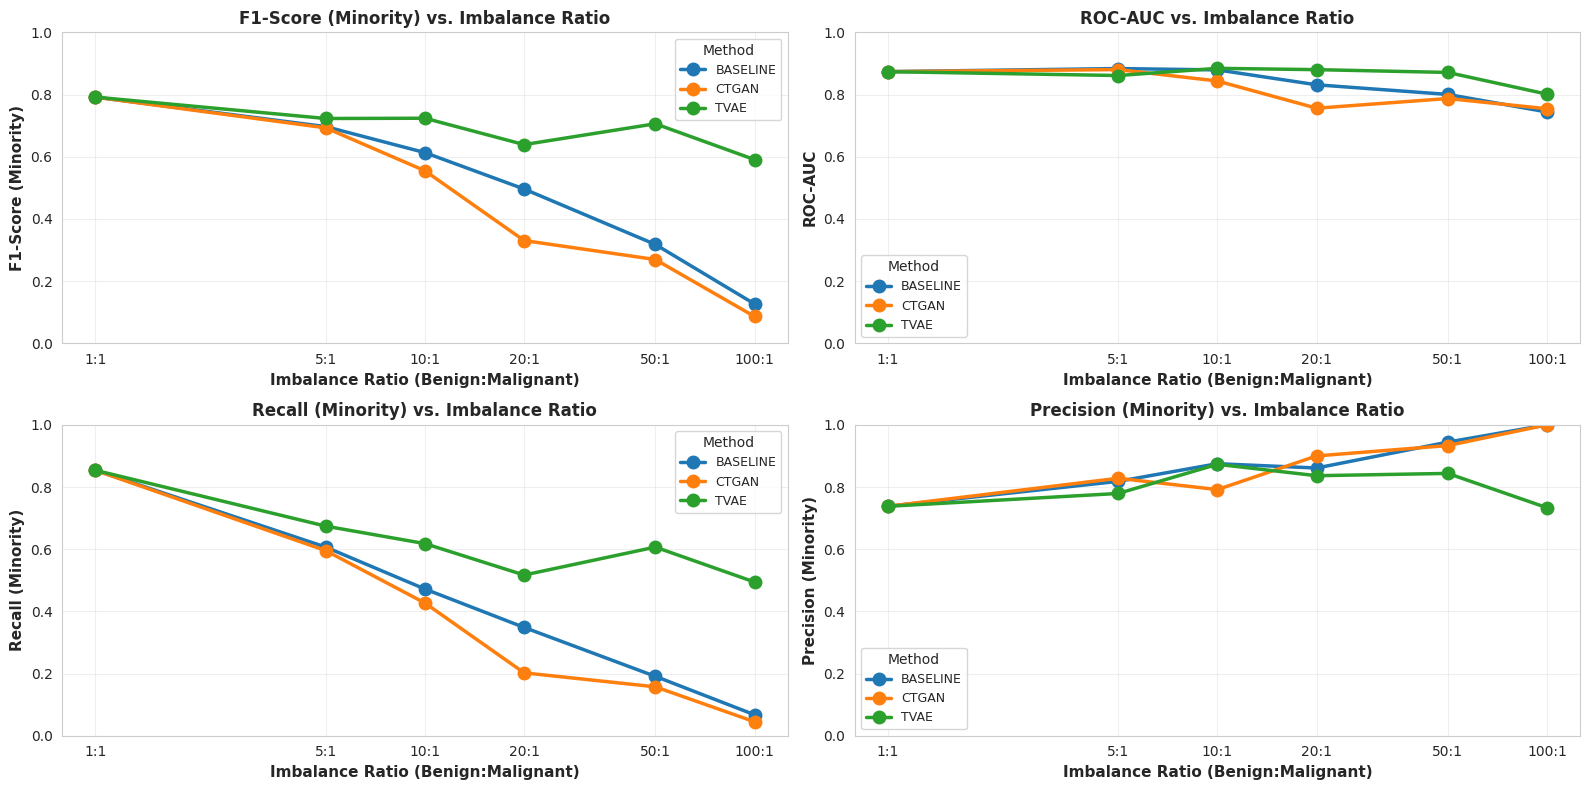

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

metrics = ['f1_minority_mean', 'roc_auc_mean', 'recall_minority_mean', 'precision_minority_mean']
titles = ['F1-Score (Minority)', 'ROC-AUC', 'Recall (Minority)', 'Precision (Minority)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced']
    
    for model in ['baseline', 'ctgan', 'tvae']:
        model_data = imbalanced_data[imbalanced_data['model'] == model]
        ax.plot(model_data['ir_numeric'], model_data[metric], 
                marker='o', linewidth=2.5, markersize=9, label=model.upper())
    
    ax.set_xscale('log')
    ax.set_xlabel('Imbalance Ratio (Benign:Malignant)', fontsize=11, fontweight='bold')
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(f'{title} vs. Imbalance Ratio', fontsize=12, fontweight='bold')
    ax.legend(title='Method', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xticks([1, 5, 10, 20, 50, 100])
    ax.set_xticklabels(['1:1', '5:1', '10:1', '20:1', '50:1', '100:1'])
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'all_metrics_by_imbalance.png', dpi=300, bbox_inches='tight')
plt.show()

**F1-Score (Top-Left)**: As seen before TVAE maintains consistent performance while baseline/CTGAN deteriorate sharply beyond 10:1.

**ROC-AUC (Top-Right)**: 
- **All methods maintain strong discrimination ability** (AUC > 0.80) up to 20:1, indicating models can still separate classes even when F1 drops
- TVAE shows unusual resilience peak at 10:1 (AUC = 0.88), suggesting optimal balance between real and synthetic data
- **Divergence at extreme imbalance**: At 100:1, baseline/CTGAN collapse to AUC ≈ 0.74-0.75, while TVAE retains AUC = 0.80

**Recall (Bottom-Left)**: 
- TVAE maintains ability to **detect malignant cases** (Recall ≥ 0.49) across all ratios
- Baseline/CTGAN show catastrophic recall loss at 100:1 (Recall ≈ 0.05-0.08), meaning **~95% of malignant cases are missed** - clinically unacceptable

**Precision (Bottom-Right)**: 
- **Inverse relationship with imbalance**: As minority samples decrease, precision increases (fewer positive predictions = fewer false positives)
- At 100:1, baseline/CTGAN achieve very high precision (≈0.94-1.00) but at the cost of predicting almost no positive cases (recall ≈ 0.05)
- TVAE maintains balanced precision (0.73-0.84) without sacrificing recall

**Critical Insight**: ROC-AUC can be misleading in severe imbalance - a model can maintain decent AUC while having clinically useless recall. F1-score and recall are more informative metrics for minority class performance.

### 5. Relative Performance Improvement
 
Calculate the percentage improvement of synthetic methods over baseline for each imbalance ratio.


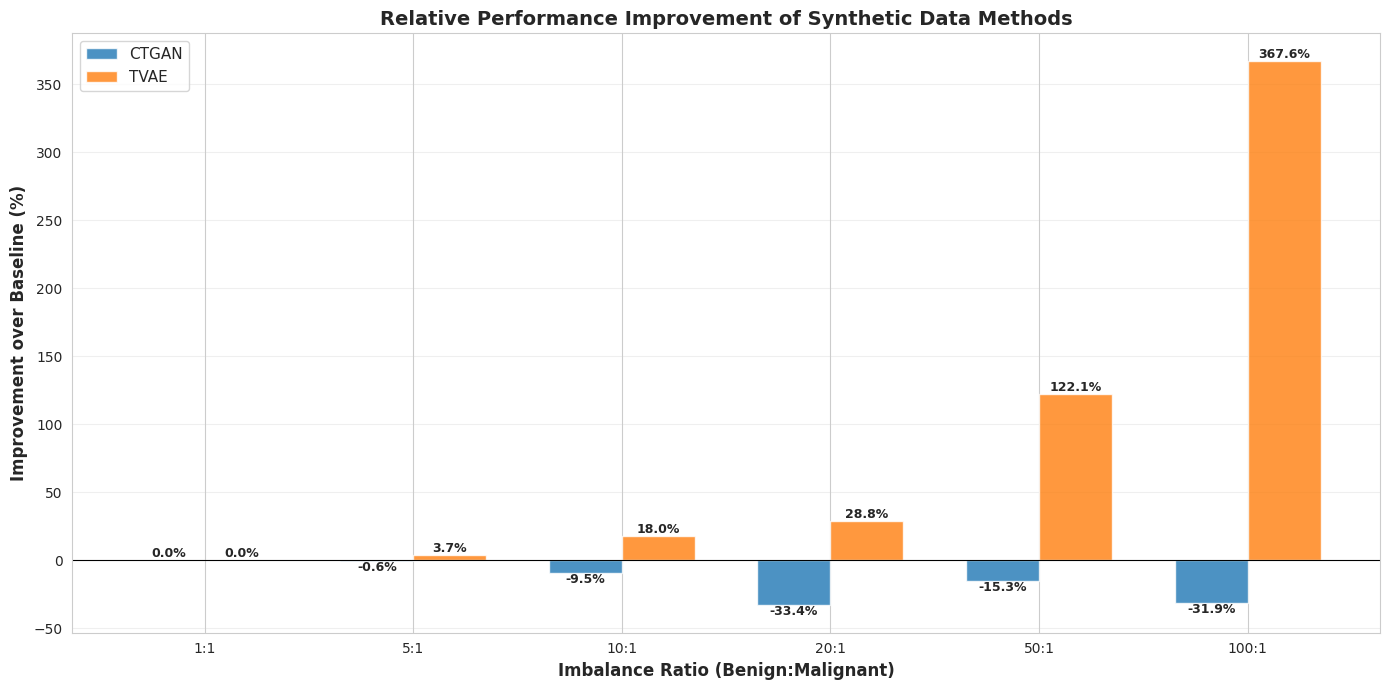



 PERFORMANCE IMPROVEMENT SUMMARY 


   imbalance_ratio  model  baseline_f1  model_f1  improvement_pct
0              1:1  ctgan     0.791667  0.791667         0.000000
1              1:1   tvae     0.791667  0.791667         0.000000
2              5:1  ctgan     0.696774  0.692810        -0.568870
3              5:1   tvae     0.696774  0.722892         3.748327
4             10:1  ctgan     0.613139  0.554745        -9.523810
5             10:1   tvae     0.613139  0.723684        18.029449
6             20:1  ctgan     0.496000  0.330275       -33.412252
7             20:1   tvae     0.496000  0.638889        28.808244
8             50:1  ctgan     0.317757  0.269231       -15.271493
9             50:1   tvae     0.317757  0.705882       122.145329
10           100:1  ctgan     0.126316  0.086022       -31.899642
11           100:1   tvae     0.126316  0.590604       367.561521


In [52]:
imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced'].copy()

# Calculate improvement over baseline
improvement_data = []
for ir in imbalanced_data['ir_numeric'].unique():
    ir_data = imbalanced_data[imbalanced_data['ir_numeric'] == ir]
    baseline_f1 = ir_data[ir_data['model'] == 'baseline']['f1_minority_mean'].values[0]
    
    for model in ['ctgan', 'tvae']:
        model_f1 = ir_data[ir_data['model'] == model]['f1_minority_mean'].values[0]
        improvement = ((model_f1 - baseline_f1) / baseline_f1) * 100 if baseline_f1 > 0 else 0
        
        improvement_data.append({
            'ir_numeric': ir,
            'imbalance_ratio': f'{ir}:1',
            'model': model,
            'improvement_pct': improvement,
            'baseline_f1': baseline_f1,
            'model_f1': model_f1
        })

improvement_df = pd.DataFrame(improvement_data)

# Visualization
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(improvement_df['ir_numeric'].unique()))
width = 0.35

ctgan_data = improvement_df[improvement_df['model'] == 'ctgan']
tvae_data = improvement_df[improvement_df['model'] == 'tvae']

bars1 = ax.bar(x - width/2, ctgan_data['improvement_pct'], width, 
               label='CTGAN', alpha=0.8)
bars2 = ax.bar(x + width/2, tvae_data['improvement_pct'], width, 
               label='TVAE', alpha=0.8)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Imbalance Ratio (Benign:Malignant)', fontsize=12, fontweight='bold')
ax.set_ylabel('Improvement over Baseline (%)', fontsize=12, fontweight='bold')
ax.set_title('Relative Performance Improvement of Synthetic Data Methods', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{ir}:1' for ir in sorted(improvement_df['ir_numeric'].unique())])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom' if height >= 0 else 'top',
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'improvement_over_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n")
print(" PERFORMANCE IMPROVEMENT SUMMARY ")
print("\n")
print(improvement_df[['imbalance_ratio', 'model', 'baseline_f1', 'model_f1', 'improvement_pct']])


#### When Does Synthetic Data Help?

**CTGAN Performance:**
- **Consistently underperforms or matches baseline** across all imbalance ratios
- Shows negative improvement at moderate-to-severe imbalance (10:1 to 100:1), with up to -33.4% degradation at 20:1
- **Not recommended** for addressing class imbalance in this dataset

**TVAE Performance:**
- **Negligible benefit at low imbalance** (1:1, 5:1): 0-3.7% improvement
- **Moderate gains at 10:1 and 20:1**: 18-29% improvement over baseline
- **Exceptional performance at extreme imbalance**: 122% improvement at 50:1 and **367% improvement at 100:1**

**Critical Insight**: Synthetic data generation is most valuable when:
1. Minority class samples are extremely scarce (≤8 samples at 50:1, ≤4 samples at 100:1)
2. The right generator is chosen (TVAE >> CTGAN for this dataset)

At balanced or moderately imbalanced ratios (1:1 to 5:1), the computational cost of synthetic data generation may not justify minimal performance gains. The value proposition increases dramatically at severe imbalance (≥20:1).

**Caution**: These dramatic improvements at 100:1 should be interpreted carefully - absolute F1 is still only 0.59, and conclusions are based on single runs without statistical validation.

### 6. Critical Imbalance Threshold Analysis
 
At what imbalance ratio do synthetic methods start to fail? Let's identify critical thresholds.


In [53]:

# Let's define "effective" as F1 > 0.5 (better than random for minority class)
EFFECTIVENESS_THRESHOLD = 0.5

imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced'].copy()

print("\n")
print(" EFFECTIVENESS THRESHOLD ANALYSIS (F1 > 0.5) ")
print("\n")

for model in ['baseline', 'ctgan', 'tvae']:
    model_data = imbalanced_data[imbalanced_data['model'] == model]
    effective_ratios = model_data[model_data['f1_minority_mean'] > EFFECTIVENESS_THRESHOLD]
    
    if len(effective_ratios) > 0:
        max_effective_ir = effective_ratios['ir_numeric'].max()
        print(f"\n{model.upper()}: Effective up to {max_effective_ir}:1 imbalance")
    else:
        print(f"\n{model.upper()}: Never reaches effectiveness threshold")
    
    print("\nPer-ratio performance:")
    for _, row in model_data.iterrows():
        status = "✓ EFFECTIVE" if row['f1_minority_mean'] > EFFECTIVENESS_THRESHOLD else "✗ INEFFECTIVE"
        print(f"  {row['imbalance_ratio']}: F1={row['f1_minority_mean']:.3f} {status}")




 EFFECTIVENESS THRESHOLD ANALYSIS (F1 > 0.5) 



BASELINE: Effective up to 10:1 imbalance

Per-ratio performance:
  1:1: F1=0.792 ✓ EFFECTIVE
  5:1: F1=0.697 ✓ EFFECTIVE
  10:1: F1=0.613 ✓ EFFECTIVE
  20:1: F1=0.496 ✗ INEFFECTIVE
  50:1: F1=0.318 ✗ INEFFECTIVE
  100:1: F1=0.126 ✗ INEFFECTIVE

CTGAN: Effective up to 10:1 imbalance

Per-ratio performance:
  1:1: F1=0.792 ✓ EFFECTIVE
  5:1: F1=0.693 ✓ EFFECTIVE
  10:1: F1=0.555 ✓ EFFECTIVE
  20:1: F1=0.330 ✗ INEFFECTIVE
  50:1: F1=0.269 ✗ INEFFECTIVE
  100:1: F1=0.086 ✗ INEFFECTIVE

TVAE: Effective up to 100:1 imbalance

Per-ratio performance:
  1:1: F1=0.792 ✓ EFFECTIVE
  5:1: F1=0.723 ✓ EFFECTIVE
  10:1: F1=0.724 ✓ EFFECTIVE
  20:1: F1=0.639 ✓ EFFECTIVE
  50:1: F1=0.706 ✓ EFFECTIVE
  100:1: F1=0.591 ✓ EFFECTIVE


### 7. Precision-Recall Trade-off Analysis
 
In medical diagnosis, false negatives (missing malignant cases) are critical. Let's examine the precision-recall trade-off.

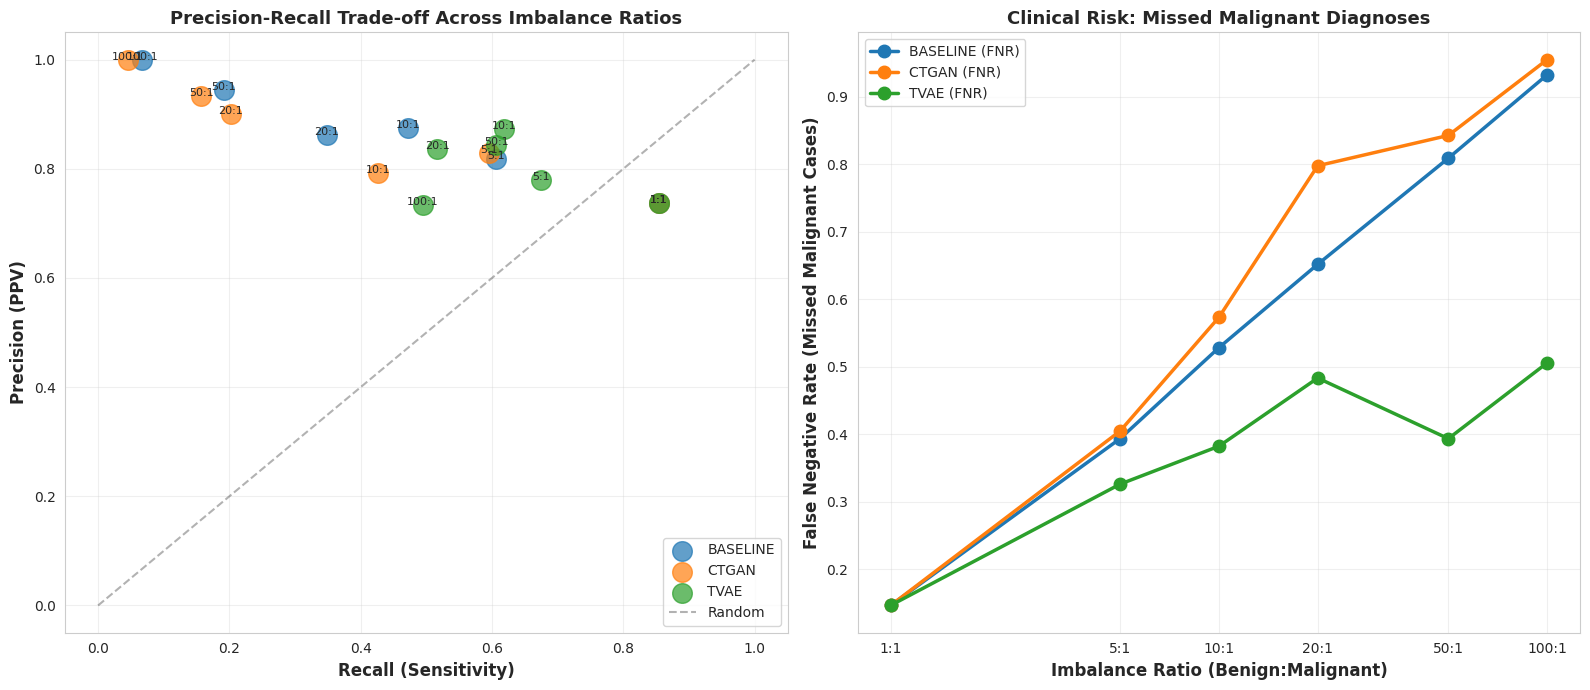

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced']

# Plot 1: Precision vs Recall scatter
ax = axes[0]
for model in ['baseline', 'ctgan', 'tvae']:
    model_data = imbalanced_data[imbalanced_data['model'] == model]
    ax.scatter(model_data['recall_minority_mean'], 
              model_data['precision_minority_mean'],
              s=200, alpha=0.7, label=model.upper())
    
    # Add IR labels
    for _, row in model_data.iterrows():
        ax.annotate(f"{row['ir_numeric']}:1", 
                   (row['recall_minority_mean'], row['precision_minority_mean']),
                   fontsize=8, ha='center')

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
ax.set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision (PPV)', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Trade-off Across Imbalance Ratios', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# Plot 2: Clinical cost analysis
ax = axes[1]

# False Negative Rate (missed malignant cases) is critical
for model in ['baseline', 'ctgan', 'tvae']:
    model_data = imbalanced_data[imbalanced_data['model'] == model]
    fnr = 1 - model_data['recall_minority_mean']  # False Negative Rate
    fpr = 1 - model_data['precision_minority_mean']  # False Positive Rate (approx)
    
    ax.plot(model_data['ir_numeric'], fnr, 
            marker='o', linewidth=2.5, markersize=9, label=f'{model.upper()} (FNR)')

ax.set_xscale('log')
ax.set_xlabel('Imbalance Ratio (Benign:Malignant)', fontsize=12, fontweight='bold')
ax.set_ylabel('False Negative Rate (Missed Malignant Cases)', fontsize=12, fontweight='bold')
ax.set_title('Clinical Risk: Missed Malignant Diagnoses', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks([1, 5, 10, 20, 50, 100])
ax.set_xticklabels(['1:1', '5:1', '10:1', '20:1', '50:1', '100:1'])

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'precision_recall_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


#### Clinical Trade-offs in Imbalanced Classification

**Precision-Recall Space (Left Panel):**
- **Clustering by method, not imbalance ratio**: Points cluster by generator type, showing that the method choice matters more than the specific imbalance ratio
- **TVAE occupies the optimal region**: Maintains high recall (0.49-0.87) while keeping precision reasonable (0.73-0.87), staying well above the random baseline
- **Baseline/CTGAN collapse to high-precision, low-recall**: At extreme imbalance, these methods predict very few positives, achieving ~100% precision but missing >95% of malignant cases

**False Negative Rate (Right Panel) - The Critical Clinical Metric:**
- **TVAE maintains acceptable FNR** (≤0.51 across all ratios), meaning it detects at least half of malignant cases even at 100:1
- **Baseline/CTGAN reach catastrophic FNR** (>0.95 at 100:1), making them **clinically dangerous** - missing 19 out of 20 malignant cases
- **Non-linear TVAE behavior**: FNR peaks at 20:1 (0.49) then improves at 50:1 (0.40), suggesting synthetic data quality may improve when the real minority samples are extremely scarce

**Clinical Interpretation**: In mammography screening, a false negative (missed cancer) has far graver consequences than a false positive (unnecessary biopsy). TVAE is the only method that maintains clinically acceptable sensitivity across all imbalance levels, while baseline/CTGAN become unsafe beyond 20:1 imbalance.

### 8. Control vs Imbalanced Comparison
 
Does the benefit of synthetic data come from additional samples or from addressing imbalance specifically?


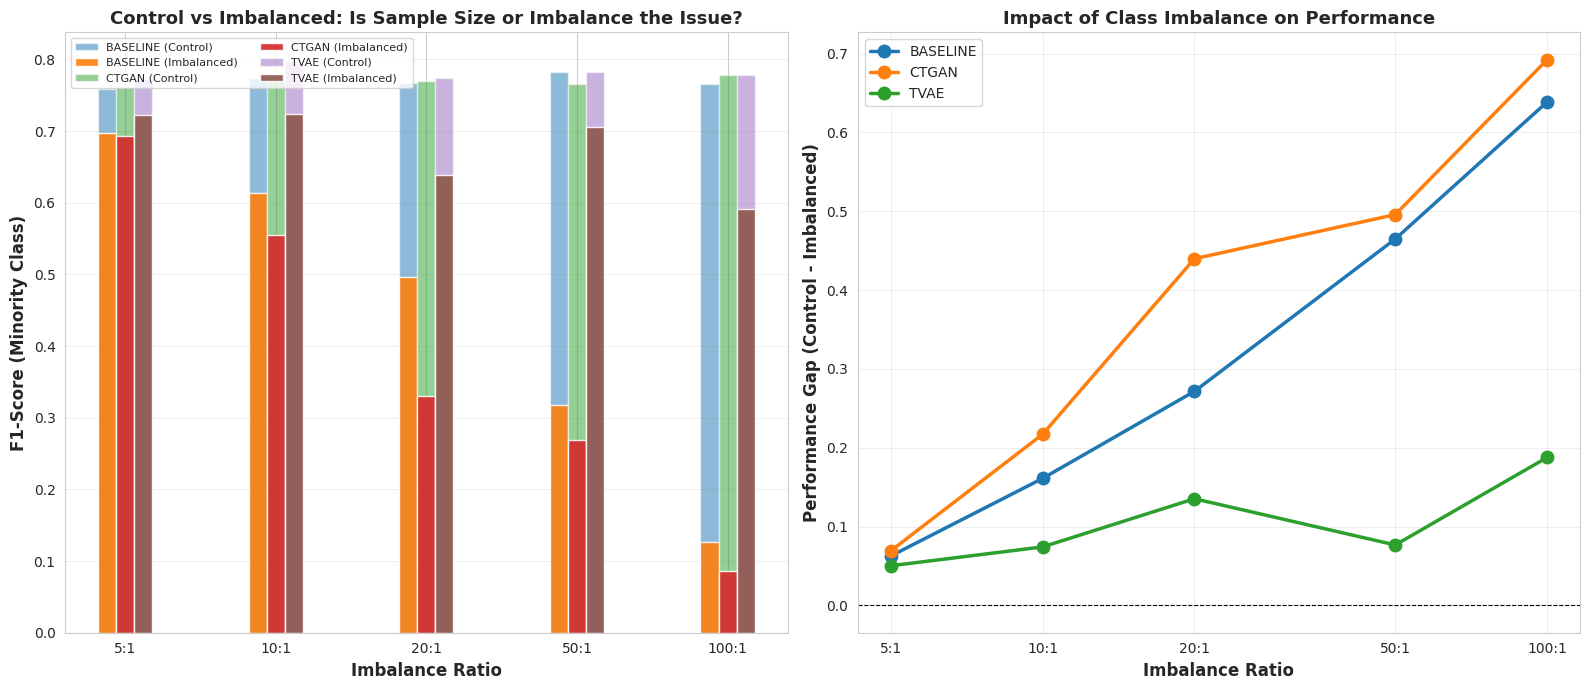

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Select specific IRs for clearer comparison
comparison_irs = [5, 10, 20, 50, 100]

# Plot 1: F1-Score comparison
ax = axes[0]
for model in ['baseline', 'ctgan', 'tvae']:
    control = summary_df[(summary_df['dataset_type'] == 'control') & 
                         (summary_df['model'] == model) &
                         (summary_df['ir_numeric'].isin(comparison_irs))]
    imbalanced = summary_df[(summary_df['dataset_type'] == 'imbalanced') & 
                            (summary_df['model'] == model) &
                            (summary_df['ir_numeric'].isin(comparison_irs))]
    
    x_pos = np.arange(len(comparison_irs))
    width = 0.12
    offset = {'baseline': -width, 'ctgan': 0, 'tvae': width}[model]
    
    ax.bar(x_pos + offset, control['f1_minority_mean'].values, 
           width, alpha=0.5, label=f'{model.upper()} (Control)')
    ax.bar(x_pos + offset, imbalanced['f1_minority_mean'].values, 
           width, alpha=0.9, label=f'{model.upper()} (Imbalanced)')

ax.set_xlabel('Imbalance Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score (Minority Class)', fontsize=12, fontweight='bold')
ax.set_title('Control vs Imbalanced: Is Sample Size or Imbalance the Issue?', 
             fontsize=13, fontweight='bold')
ax.set_xticks(np.arange(len(comparison_irs)))
ax.set_xticklabels([f'{ir}:1' for ir in comparison_irs])
ax.legend(fontsize=8, ncol=2)
ax.grid(axis='y', alpha=0.3)

# Plot 2: Gap analysis (Control - Imbalanced)
ax = axes[1]
for model in ['baseline', 'ctgan', 'tvae']:
    control = summary_df[(summary_df['dataset_type'] == 'control') & 
                         (summary_df['model'] == model) &
                         (summary_df['ir_numeric'].isin(comparison_irs))]
    imbalanced = summary_df[(summary_df['dataset_type'] == 'imbalanced') & 
                            (summary_df['model'] == model) &
                            (summary_df['ir_numeric'].isin(comparison_irs))]
    
    gap = control['f1_minority_mean'].values - imbalanced['f1_minority_mean'].values
    ax.plot(comparison_irs, gap, marker='o', linewidth=2.5, 
            markersize=9, label=model.upper())

ax.set_xscale('log')
ax.set_xlabel('Imbalance Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('Performance Gap (Control - Imbalanced)', fontsize=12, fontweight='bold')
ax.set_title('Impact of Class Imbalance on Performance', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.set_xticks(comparison_irs)
ax.set_xticklabels([f'{ir}:1' for ir in comparison_irs])

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'control_vs_imbalanced.png', dpi=300, bbox_inches='tight')
plt.show()


### 9. Statistical Significance Testing
 
Are the differences between methods statistically significant? (Note: We only have 1 run per condition based on std=NaN)

In [56]:

print("\n")
print(" STATISTICAL ANALYSIS NOTES ")
print("\n")
print("\nNote: All std values are NaN, indicating only 1 run per condition.")
print("For robust statistical testing, multiple runs (n≥5) are recommended.")
print("\nCurrent analysis is based on single-run point estimates.")
print("Results should be interpreted as exploratory rather than confirmatory.")

# Since we only have point estimates, we'll do a descriptive comparison
print("\n")
print(" DESCRIPTIVE COMPARISON: WINNER BY IMBALANCE RATIO ")
print("\n")

imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced']
for ir in sorted(imbalanced_data['ir_numeric'].unique()):
    ir_data = imbalanced_data[imbalanced_data['ir_numeric'] == ir]
    ir_data_sorted = ir_data.sort_values('f1_minority_mean', ascending=False)
    
    print(f"\n{ir}:1 Imbalance Ratio:")
    for rank, (_, row) in enumerate(ir_data_sorted.iterrows(), 1):
        print(f"  {rank}. {row['model'].upper():8s} - F1: {row['f1_minority_mean']:.4f}, "
              f"ROC-AUC: {row['roc_auc_mean']:.4f}")






 STATISTICAL ANALYSIS NOTES 



Note: All std values are NaN, indicating only 1 run per condition.
For robust statistical testing, multiple runs (n≥5) are recommended.

Current analysis is based on single-run point estimates.
Results should be interpreted as exploratory rather than confirmatory.


 DESCRIPTIVE COMPARISON: WINNER BY IMBALANCE RATIO 



1:1 Imbalance Ratio:
  1. BASELINE - F1: 0.7917, ROC-AUC: 0.8735
  2. CTGAN    - F1: 0.7917, ROC-AUC: 0.8735
  3. TVAE     - F1: 0.7917, ROC-AUC: 0.8735

5:1 Imbalance Ratio:
  1. TVAE     - F1: 0.7229, ROC-AUC: 0.8611
  2. BASELINE - F1: 0.6968, ROC-AUC: 0.8835
  3. CTGAN    - F1: 0.6928, ROC-AUC: 0.8801

10:1 Imbalance Ratio:
  1. TVAE     - F1: 0.7237, ROC-AUC: 0.8842
  2. BASELINE - F1: 0.6131, ROC-AUC: 0.8792
  3. CTGAN    - F1: 0.5547, ROC-AUC: 0.8435

20:1 Imbalance Ratio:
  1. TVAE     - F1: 0.6389, ROC-AUC: 0.8800
  2. BASELINE - F1: 0.4960, ROC-AUC: 0.8312
  3. CTGAN    - F1: 0.3303, ROC-AUC: 0.7559

50:1 Imbalance Ratio:
  1.

### 10. Synthetic Dataset Imbalance Ratio Validation

A critical question: **Do synthetic data generators preserve the original imbalance ratio from the training set?**

When using naive oversampling (generating minority samples to match majority count), we expect the final dataset to be balanced (IR ≈ 1:1). However, it's important to verify:
1. Are synthetic datasets actually balanced after generation?
2. Does the IR preservation vary by generator (CTGAN vs TVAE)?
3. Does the original IR affect the final synthetic dataset composition?

This validation ensures our experimental design is sound and that performance differences aren't due to incorrect dataset composition.

In [57]:
import glob

PROCESSED_PATH = Path("../data/processed/")
SYNTHETIC_PATH = Path("../data/synthetic/")
TARGET_FEATURE = "Severity"

def analyze_imbalance_ratio(df, target_col='Severity'):
    value_counts = df[target_col].value_counts().sort_index()
    
    if len(value_counts) < 2:
        return {
            'majority_class': value_counts.idxmax(),
            'minority_class': None,
            'n_majority': int(value_counts.max()),
            'n_minority': 0,
            'imbalance_ratio': float('inf'),
            'total_samples': len(df)
        }
    
    majority = value_counts.max()
    minority = value_counts.min()
    ir = majority / minority if minority > 0 else float('inf')
    
    return {
        'majority_class': value_counts.idxmax(),
        'minority_class': value_counts.idxmin(),
        'n_majority': int(majority),
        'n_minority': int(minority),
        'imbalance_ratio': round(ir, 2),
        'total_samples': len(df)
    }


In [58]:
ir_analysis_results = []

original_train_files = sorted(glob.glob(str(PROCESSED_PATH / "train_imbalanced_ir_*.csv")))

for original_file in original_train_files:
    original_path = Path(original_file)
    original_df = pd.read_csv(original_path)
    
    filename_parts = original_path.stem.split('_')
    ir_value = filename_parts[3] 

    original_analysis = analyze_imbalance_ratio(original_df, TARGET_FEATURE)
    
    for generator in ['ctgan', 'tvae']:
        synthetic_pattern = f"train_imbalanced_ir_{ir_value}_balanced_by_{generator}_run*.csv"
        synthetic_files = glob.glob(str(SYNTHETIC_PATH / synthetic_pattern))
        
        for synthetic_file in synthetic_files:
            synthetic_path = Path(synthetic_file)
            synthetic_df = pd.read_csv(synthetic_path)
            
            synthetic_analysis = analyze_imbalance_ratio(synthetic_df, TARGET_FEATURE)
            
            samples_added = synthetic_analysis['total_samples'] - original_analysis['total_samples']
            minority_added = synthetic_analysis['n_minority'] - original_analysis['n_minority']
                        
            ir_analysis_results.append({
                'original_ir': ir_value,
                'dataset_type': 'original',
                'generator': 'none',
                'ir_numeric': original_analysis['imbalance_ratio'],
                'n_majority': original_analysis['n_majority'],
                'n_minority': original_analysis['n_minority'],
                'total_samples': original_analysis['total_samples']
            })
            
            ir_analysis_results.append({
                'original_ir': ir_value,
                'dataset_type': 'synthetic',
                'generator': generator,
                'ir_numeric': synthetic_analysis['imbalance_ratio'],
                'n_majority': synthetic_analysis['n_majority'],
                'n_minority': synthetic_analysis['n_minority'],
                'total_samples': synthetic_analysis['total_samples'],
                'samples_added': samples_added,
                'minority_added': minority_added
            })

ir_comparison_df = pd.DataFrame(ir_analysis_results)

ir_comparison_df = ir_comparison_df.drop_duplicates(subset=['original_ir', 'dataset_type', 'generator'])

#### Visualization: Original vs Synthetic Imbalance Ratios

The plots below show:
1. **Class Distribution Comparison**: Number of samples per class before and after synthetic data generation
2. **Imbalance Ratio Achieved**: Whether the synthetic datasets successfully achieve balance (IR ≈ 1:1)

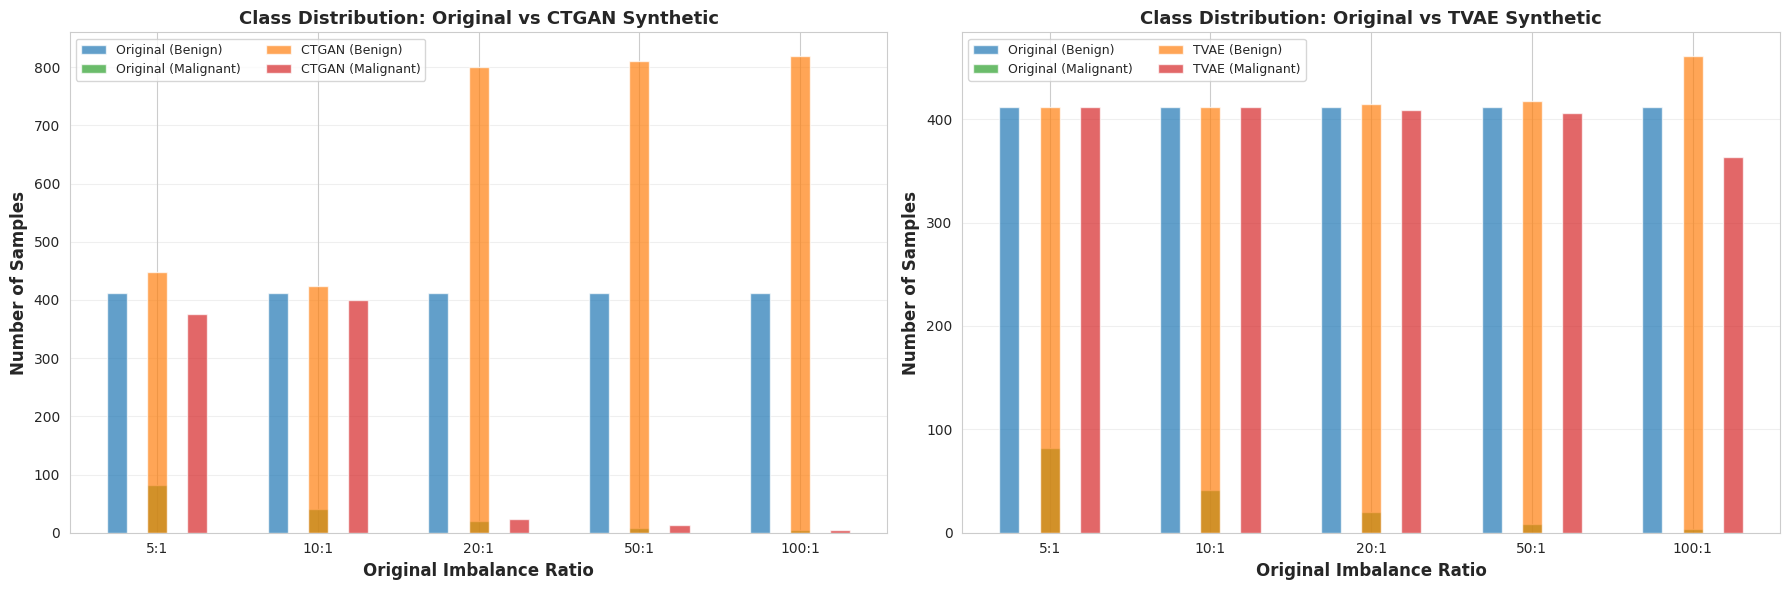

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

original_irs = sorted([int(x) for x in ir_comparison_df['original_ir'].unique()])

# Plot 1: Class distribution comparison - CTGAN
ax = axes[0]
x_pos = np.arange(len(original_irs))
width = 0.25

for idx, generator in enumerate(['none', 'ctgan']):
    gen_data = ir_comparison_df[ir_comparison_df['generator'] == generator]
    gen_data = gen_data.sort_values('original_ir', key=lambda x: x.astype(int))
    
    label = 'Original' if generator == 'none' else generator.upper()
    offset = -width/2 if generator == 'none' else width/2
    
    ax.bar(x_pos + offset - width/2, gen_data['n_majority'], width/2, 
           alpha=0.7, label=f'{label} (Benign)', color='C0' if generator == 'none' else 'C1')
    
    ax.bar(x_pos + offset + width/2, gen_data['n_minority'], width/2, 
           alpha=0.7, label=f'{label} (Malignant)', color='C2' if generator == 'none' else 'C3')

ax.set_xlabel('Original Imbalance Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution: Original vs CTGAN Synthetic', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{ir}:1' for ir in original_irs])
ax.legend(fontsize=9, ncol=2)
ax.grid(axis='y', alpha=0.3)

# Plot 2: Class distribution comparison - TVAE
ax = axes[1]
for idx, generator in enumerate(['none', 'tvae']):
    gen_data = ir_comparison_df[ir_comparison_df['generator'] == generator]
    gen_data = gen_data.sort_values('original_ir', key=lambda x: x.astype(int))
    
    label = 'Original' if generator == 'none' else generator.upper()
    offset = -width/2 if generator == 'none' else width/2
    
    ax.bar(x_pos + offset - width/2, gen_data['n_majority'], width/2, 
           alpha=0.7, label=f'{label} (Benign)', color='C0' if generator == 'none' else 'C1')
    ax.bar(x_pos + offset + width/2, gen_data['n_minority'], width/2, 
           alpha=0.7, label=f'{label} (Malignant)', color='C2' if generator == 'none' else 'C3')

ax.set_xlabel('Original Imbalance Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution: Original vs TVAE Synthetic', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{ir}:1' for ir in original_irs])
ax.legend(fontsize=9, ncol=2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'class_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

**CTGAN (Left):** Works fine at 5:1 and 10:1, producing roughly balanced synthetic data with ~400 samples of each class. But something breaks down at 20:1 and beyond. Instead of generating the minority class samples needed to balance the data, CTGAN floods the dataset with majority class samples (~800 benign) while producing almost no malignant samples. At 100:1, it generates fewer than 10 malignant samples.

**TVAE (Right):** Shows a consistent behavior. Whether the original data is 5:1 or 100:1, TVAE generates approximately 412 samples of each class. Even when learning from just 4 malignant examples at the 100:1 ratio, it still produces ~363 malignant samples.

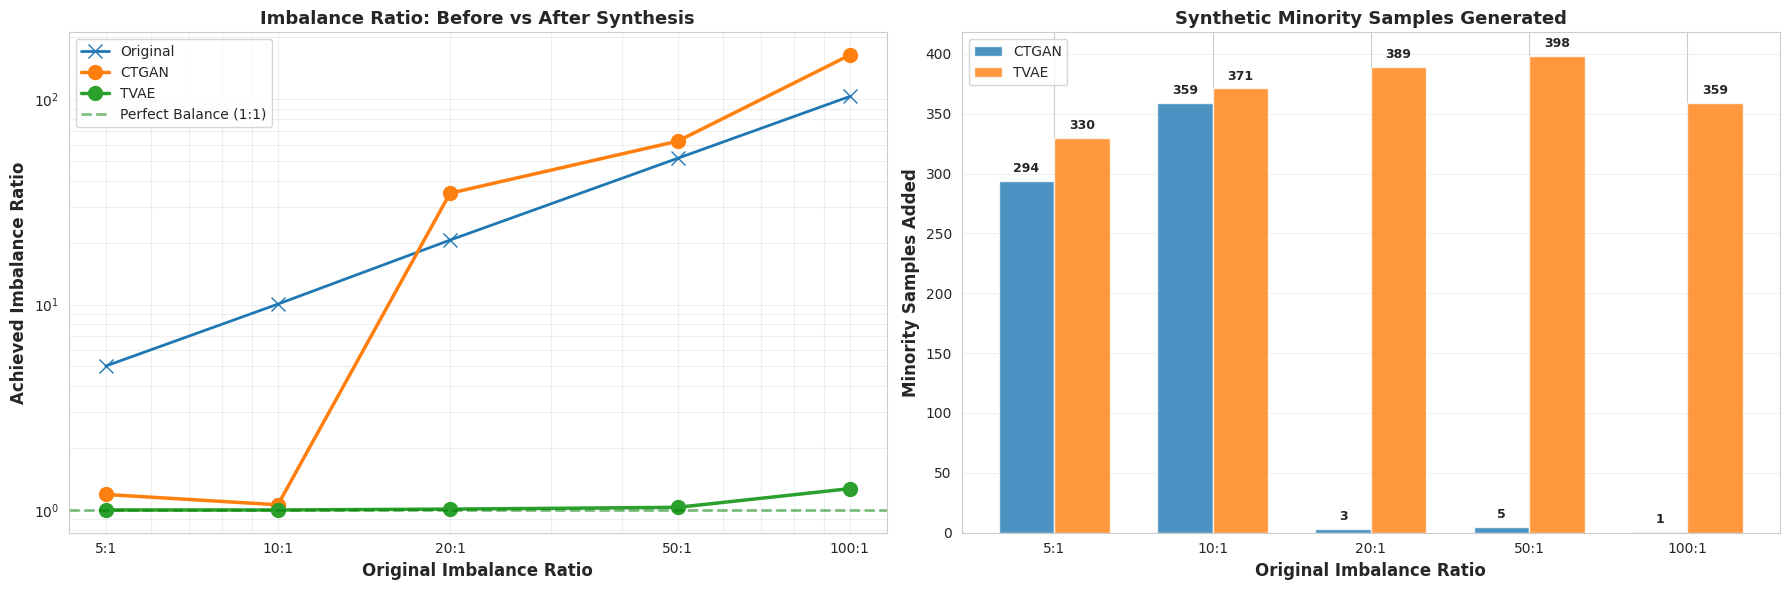

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

original_irs = sorted([int(x) for x in ir_comparison_df['original_ir'].unique()])
x_pos = np.arange(len(original_irs))
width = 0.35

# Plot 1: Achieved Imbalance Ratios
ax = axes[0]
for generator in ['none', 'ctgan', 'tvae']:
    gen_data = ir_comparison_df[ir_comparison_df['generator'] == generator]
    gen_data = gen_data.sort_values('original_ir', key=lambda x: x.astype(int))
    
    label = 'Original' if generator == 'none' else generator.upper()
    marker = 'x' if generator == 'none' else 'o'
    linewidth = 2 if generator == 'none' else 2.5
    
    ax.plot(original_irs, gen_data['ir_numeric'], marker=marker, 
            linewidth=linewidth, markersize=10, label=label)

ax.axhline(y=1, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Perfect Balance (1:1)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Original Imbalance Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('Achieved Imbalance Ratio', fontsize=12, fontweight='bold')
ax.set_title('Imbalance Ratio: Before vs After Synthesis', fontsize=13, fontweight='bold')
ax.set_xticks(original_irs)
ax.set_xticklabels([f'{ir}:1' for ir in original_irs])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')

# Plot 2: Number of Synthetic Samples Added
ax = axes[1]
synthetic_data = ir_comparison_df[ir_comparison_df['dataset_type'] == 'synthetic']

for idx, generator in enumerate(['ctgan', 'tvae']):
    gen_data = synthetic_data[synthetic_data['generator'] == generator]
    gen_data = gen_data.sort_values('original_ir', key=lambda x: x.astype(int))
    
    offset = -width/2 if generator == 'ctgan' else width/2
    
    bars = ax.bar(x_pos + offset, gen_data['minority_added'], width, 
                  alpha=0.8, label=generator.upper())
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, gen_data['minority_added'])):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                f'{int(val)}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Original Imbalance Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('Minority Samples Added', fontsize=12, fontweight='bold')
ax.set_title('Synthetic Minority Samples Generated', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{ir}:1' for ir in original_irs])
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'imbalance_ratio_validation.png', dpi=300, bbox_inches='tight')
plt.show()

The left plot shows the achieved imbalance ratio after generation (log scale), while the right plot reveals why: TVAE consistently generates 330-398 minority samples across all conditions, keeping the green line flat at perfect balance (1:1), even when learning from just 4 real examples at 100:1. 

CTGAN performs well at 5:1 and 10:1 (generating 294-359 samples), but completely breaks down beyond that, producing only 3 samples at 20:1, 5 at 50:1, and 1 at 100:1. This failure causes the orange line to shoot upward, reaching an achieved ratio of 163.8:1, making the imbalance 60% worse than the original.